In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole, SimilarityMaps
from rdkit.Chem import rdMolDescriptors


from transformers import AutoTokenizer,AutoModel

import joblib


import matplotlib.pyplot as plt
from IPython.display import display, SVG
import seaborn as sns


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


c:\Users\ACER\final_DA_for_life_science\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [2]:
# Random Forest (Baseline – Fingerprints)
rf_model = joblib.load("models/best_baseline_rf.joblib")

In [3]:
class ChemBERTaReference(nn.Module):
    def __init__(self, model_name="seyonec/ChemBERTa-zinc-base-v1"):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_emb = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_emb).squeeze(-1)
        return logits


tokenizer_bert = AutoTokenizer.from_pretrained(
    "seyonec/ChemBERTa-zinc-base-v1"
)

chemberta = ChemBERTaReference().to(device)
chemberta.load_state_dict(
    torch.load(
        "models/best_reference_chemberta_xai.pth",
        map_location=device
    )
)
chemberta.eval()

print("ChemBERTa reference model loaded correctly.")    

ChemBERTa reference model loaded correctly.


C:\Users\ACER\AppData\Local\Temp\ipykernel_49420\1259169033.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


In [4]:
best_params = {
    "hidden_dim": 64,
    "dropout": 0.3
}


In [5]:
tokenizer_meta = joblib.load("models/cnn_tokenizer_meta.joblib")
char_map = tokenizer_meta["char_map"]
vocab_sz = tokenizer_meta["vocab_sz"]
MAX_LEN = tokenizer_meta["max_len"]

In [6]:
def fast_tokenize(smiles):
    seq = [char_map.get(c, 0) for c in smiles]
    return seq + [0]*(MAX_LEN-len(seq)) if len(seq)<MAX_LEN else seq[:MAX_LEN]

In [7]:
class HybridCNNLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=64, dropout_rate=0.5):
        super(HybridCNNLSTM, self).__init__()
        
        # Embedding: Transforms integers into dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # CNN Block: Extract Local Features
        self.conv1 = nn.Conv1d(embed_dim, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64) # Helps with faster convergence
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # LSTM Block: Learn sequence dependencies
        self.lstm = nn.LSTM(64, hidden_dim, batch_first=True, bidirectional=True)
        
        # Classification Head
        self.dropout = nn.Dropout(dropout_rate) # avoid Overfit
        self.fc1 = nn.Linear(hidden_dim * 2, 64) 
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x: [batch, seq_len]
        emb = self.embedding(x).permute(0, 2, 1) # Đổi chiều cho CNN: [batch, embed, seq]
        
        # CNN Flow
        c = self.conv1(emb)
        c = self.bn1(c)
        c = self.relu(c)
        c = self.pool(c) # [batch, 64, seq_len/2]
        
        # LSTM Flow
        l_in = c.permute(0, 2, 1) # [batch, seq, feat]
        out, (hn, _) = self.lstm(l_in)
        
        # get final hidden state (combine both directions)
        final_hidden = torch.cat((hn[-2], hn[-1]), dim=1)
        
        # Fully Connected
        x = self.fc1(final_hidden)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)

cnn_lstm = HybridCNNLSTM(vocab_sz).to(device)
cnn_lstm.load_state_dict(
    torch.load("models/best_advanced_model.pth", map_location=device)
)
cnn_lstm.eval()

C:\Users\ACER\AppData\Local\Temp\ipykernel_49420\399978494.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("models/best_advanced_model.pth", map_location=dev

HybridCNNLSTM(
  (embedding): Embedding(40, 128, padding_idx=0)
  (conv1): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [8]:
query_smiles = "CCOc1ccc2nc(S(N)(=O)=O)sc2c1"  

mol = Chem.MolFromSmiles(query_smiles)
assert mol is not None, "Invalid SMILES"


In [9]:
# Fingerprint with bit info
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
    mol, radius=2, nBits=1024, bitInfo={}
)

bitInfo = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
    mol, 2, nBits=1024, bitInfo=bitInfo
)

# RF feature importance
importances = rf_model.feature_importances_

# Top contributing bits
top_bits = np.argsort(importances)[::-1][:5]

# Collect atom indices involved
highlight_atoms = set()
for b in top_bits:
    if b in bitInfo:
        for atom_idx, radius in bitInfo[b]:
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
            for bond_id in env:
                bond = mol.GetBondWithIdx(bond_id)
                highlight_atoms.add(bond.GetBeginAtomIdx())
                highlight_atoms.add(bond.GetEndAtomIdx())

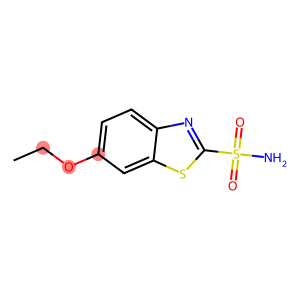

In [10]:
Draw.MolToImage(mol, highlightAtoms=list(highlight_atoms))


In [11]:
encoded = tokenizer_bert(
    query_smiles,
    return_tensors="pt",
    truncation=True,
    padding="max_length",
    max_length=128
)

input_ids = encoded["input_ids"].to(device)
attention_mask = encoded["attention_mask"].to(device)

input_ids.requires_grad = False

logit = chemberta(input_ids, attention_mask)
logit.backward()

# Gradient at embedding layer
grads = chemberta.bert.embeddings.word_embeddings.weight.grad
token_ids = input_ids[0].cpu().numpy()

token_scores = grads[token_ids].norm(dim=1).detach().cpu().numpy()


c:\Users\ACER\final_DA_for_life_science\.venv\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [12]:
tokens = tokenizer_bert.convert_ids_to_tokens(token_ids)

for t, s in zip(tokens[:30], token_scores[:30]):
    print(f"{t:>8} : {s:.4f}")


     <s> : 6.3060
    CCOc : 0.8681
       1 : 3.3611
     ccc : 2.8483
       2 : 2.7613
      nc : 2.2385
       ( : 2.2764
       S : 1.9781
       ( : 2.2764
       N : 1.1453
     )(= : 1.3156
       O : 2.1415
      )= : 2.1574
       O : 2.1415
       ) : 1.7398
      sc : 3.1620
       2 : 2.7613
       c : 1.7291
       1 : 3.3611
    </s> : 1.3163
   <pad> : 0.0000
   <pad> : 0.0000
   <pad> : 0.0000
   <pad> : 0.0000
   <pad> : 0.0000
   <pad> : 0.0000
   <pad> : 0.0000
   <pad> : 0.0000
   <pad> : 0.0000
   <pad> : 0.0000


In [13]:
cnn_lstm.train()              
cnn_lstm.zero_grad()          # clear old gradients

seq = torch.tensor(
    [fast_tokenize(query_smiles)],
    dtype=torch.long,
    device=device
)

# Forward
out = cnn_lstm(seq)

# Backward (scalar output → gradient)
out.backward()

# Get gradient at embedding layer
emb_grad = cnn_lstm.embedding.weight.grad.detach()

seq_ids = seq[0].cpu().numpy()

saliency = emb_grad[seq_ids].norm(dim=1).cpu().numpy()
saliency = saliency / (saliency.max() + 1e-8)


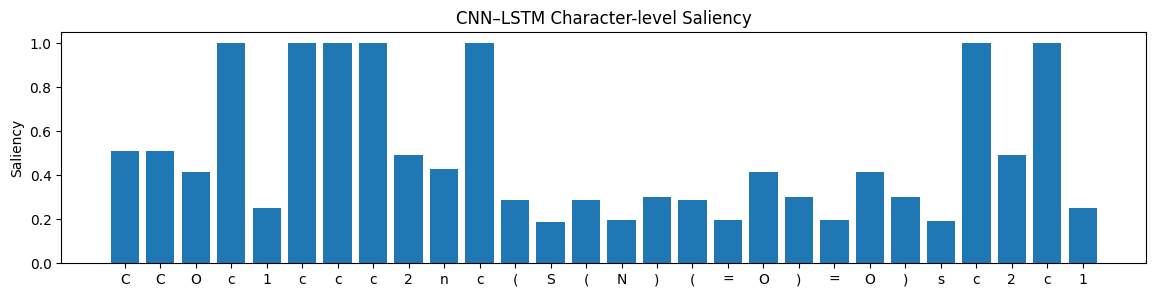

In [14]:
plt.figure(figsize=(14,3))
plt.bar(range(len(query_smiles)), saliency[:len(query_smiles)])
plt.xticks(range(len(query_smiles)), list(query_smiles))
plt.ylabel("Saliency")
plt.title("CNN–LSTM Character-level Saliency")
plt.show()